In [2]:
import requests
import csv
import os
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# Set to directory with files - default location is current directory, may need to be updated by user
# os.chdir('MY DIRECTORY')

In [3]:
from sklearn.preprocessing import MinMaxScaler

# Read data from combined dataset
data = pd.read_csv('combined_data.csv')
X = data.iloc[:, 5:10]
X

,WS2M,T2MDEW,ALLSKY_SFC_LW_DWN,ALLSKY_SFC_SW_DWN,T2M_MAX
0,1.71,2.68,27.10,7.76,8.45
1,3.01,7.99,27.25,9.94,14.69
2,2.71,11.29,29.89,6.76,15.56
3,4.63,11.62,29.95,2.21,17.26
4,4.14,-2.75,23.79,7.99,5.21
...,...,...,...,...,...
604867,1.44,-1.87,21.26,14.29,10.86
604868,3.08,10.61,27.12,10.89,21.82
604869,2.50,17.36,32.57,6.61,23.93
604870,1.55,11.63,31.29,5.67,18.62


In [4]:
import numpy as np

# Group data by date and reference location (time series for each location)
grouped = data.groupby(['Date', 'Reference'])

### Proof of concept. This will need to be wrapped into a single function for all timepoints for all locations in final model ###

# Set a group manually
group = grouped.get_group((20000101, "Atlanta"))

# Sort group by neighbor numbers to make it easier to plot on a grid
sorted_group = group.sort_values(by='Neighbor Number', ascending=True)
sorted_group

,Date,Neighbor Number,Reference,Latitude,Longitude,WS2M,T2MDEW,ALLSKY_SFC_LW_DWN,ALLSKY_SFC_SW_DWN,T2M_MAX,T2M_MIN,FROST
235228,20000101,1,Atlanta,34.2501,-83.7635,0.22,10.15,29.82,4.77,15.26,7.00,0
243629,20000101,2,Atlanta,34.7501,-83.7635,0.17,9.09,29.82,4.77,13.58,5.82,0
252030,20000101,3,Atlanta,35.2501,-83.7635,0.40,8.92,24.47,8.57,15.34,4.07,0
260431,20000101,4,Atlanta,34.2501,-84.3885,0.11,10.67,29.66,5.95,15.45,6.92,0
226827,20000101,5,Atlanta,34.7501,-84.3885,0.04,10.46,29.66,5.95,15.92,8.07,0
268832,20000101,6,Atlanta,35.2501,-84.3885,0.13,10.56,29.62,5.37,18.16,6.25,0
277233,20000101,7,Atlanta,34.2501,-85.0135,0.04,11.52,29.76,4.26,18.31,7.11,0
285634,20000101,8,Atlanta,34.7501,-85.0135,0.41,11.11,29.76,4.26,17.60,6.31,0
294035,20000101,9,Atlanta,35.2501,-85.0135,0.22,10.33,29.62,3.76,16.16,5.53,0


Next step: Get ground truth data for a tile. This is noted by neighbor number 5 in each 'group'.

In [12]:
# Collects frost for a tile based on the reference pixel (5)
frost_dict = {}

for name, group in grouped:
    reference = group[group['Neighbor Number'] == 5]
    frost_val = reference['FROST'].values[0]
    frost_dict[name] = frost_val


# Append tile data to new column
data['TILE_FROST'] = data.set_index(['Date', 'Reference']).index.map(frost_dict)

# Save updated csv
data.to_csv('output.csv', index=False)

Now make predictions for every neighbor from the data. This requires us to trian our classifier. We will use a base RF for this with scaling.

In [80]:
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, precision_score, 
                            recall_score, f1_score, roc_auc_score, roc_curve, classification_report,
                            confusion_matrix, ConfusionMatrixDisplay)
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Evaluates pipelines passed
def evaluate_pipelines(pipelines, X_train, y_train, X_evaluate, y_evaluate):
    rows = []
    for name, pipeline in pipelines:
        pipeline.fit(X_train, y_train)
        
        train_preds = pipeline.predict(X_train)
        test_preds = pipeline.predict(X_test)
        
        training_accuracy = accuracy_score(y_train, train_preds)
        testing_accuracy = accuracy_score(y_test, test_preds)

        training_recall = recall_score(y_train, train_preds)
        testing_recall = recall_score(y_test, test_preds)

        training_precision = precision_score(y_train, train_preds)
        testing_precision = precision_score(y_test, test_preds)
        
        training_f1 = f1_score(y_train, train_preds)
        testing_f1 = f1_score(y_test, test_preds)

        train_probs = pipeline.predict_proba(X_train)[:,1]
        test_probs = pipeline.predict_proba(X_test)[:,1]

        training_roc = roc_auc_score(y_train, train_probs)
        testing_roc = roc_auc_score(y_test, test_probs)
        
        rows.append({'name': name, 'Training Accuracy': training_accuracy, 'Eval Accuracy': testing_accuracy, 
                     'Training Recall': training_recall, 'Eval Recall': testing_recall,
                     'Training Precision': training_precision, 'Eval Precision': testing_precision,
                     'Training F1': training_f1, 'Eval F1': testing_f1, 'Training ROC': training_roc, 'Eval ROC': testing_roc})
        
    display(pd.DataFrame(rows))

# Plots confusion matrix
def plot_confusion_matrix(y_true, y_pred, clf_name):
    # Generate confusion matrix
    cm = confusion_matrix(y_true, y_pred)
     
    # Create figure
    plt.figure()
     
    # Use seaborn to plot confusion matrix
    sns.heatmap(cm, annot = True, fmt = 'g', cmap='viridis')
     
    # Labels/title
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'{clf_name} Confusion Matrix')
     
    # Display plot
    plt.show()

def plot_roc_curve(y_test, y_probs):

  #calculate auc
  auc = roc_auc_score(y_test, y_probs)

  #plot
  fpr, tpr, _ = roc_curve(y_test, y_probs)
  plt.plot(fpr, tpr, label=f"AUC = {auc:.5f}")
  plt.plot([0, 1], [0, 1], 'k--')
  plt.xlabel("False Positive Rate")
  plt.ylabel("True Positive Rate")
  plt.title("ROC Curve")
  plt.legend()
  plt.show()

# Scaling features
scaler = MinMaxScaler()

# Build random forest with scaler
random_forest = make_pipeline(scaler, RandomForestClassifier(random_state = 1234))
y = data['FROST']

# Group by tile
tile_groups = data[['Date', 'Reference']].drop_duplicates()

# Split groups — this keeps all 9 neighbors together
group_train, group_test = train_test_split(
    tile_groups, test_size=0.2, random_state=1234
)

# Join back to original data to get full rows
data_train = data.merge(group_train, on=['Date', 'Reference'], how='inner')
data_test = data.merge(group_test, on=['Date', 'Reference'], how='inner')

feature_columns = X.columns

# Features from training data
X_train = data_train[feature_columns]
# Ground truth from training set
y_train = data_train['FROST']

# Features from testing data
X_test = data_test[feature_columns]
# Ground truth from testing set
y_test = data_test['FROST']

# CLFs to plot confusion matrix for (just random forest in this file)
clfs = [('Random Forest', random_forest)]

# Train models specified
for name, clf in clfs:
    print(f"\nTraining {name}...")
    clf.fit(X_train, y_train)

# Generate predictions
y_preds_train = random_forest.predict(X_train)
y_preds_test = random_forest.predict(X_test)
y_preds = np.concatenate([y_preds_train, y_preds_test])

# Get probabilities
y_probs_test = random_forest.predict_proba(X_test)[:,1]

# Put predictions into data matrix
data_test['PRED'] = y_preds_test
data_test['PROB'] = y_probs_test

print("Training Complete")


Training Random Forest...
Training Complete


,name,Accuracy,Recall,Precision,F1,ROC
0,Random Forest Baseline,0.944205,0.708714,0.681564,0.694874,0.974824


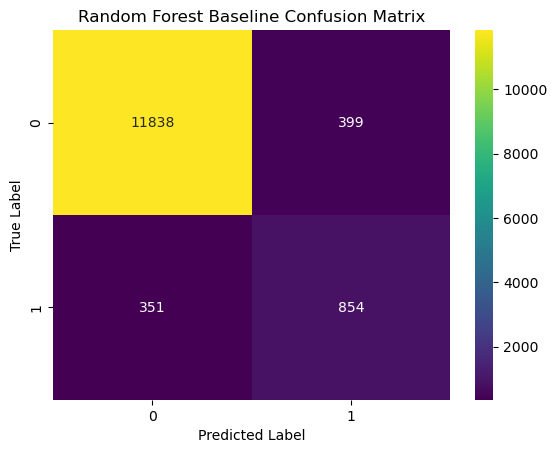

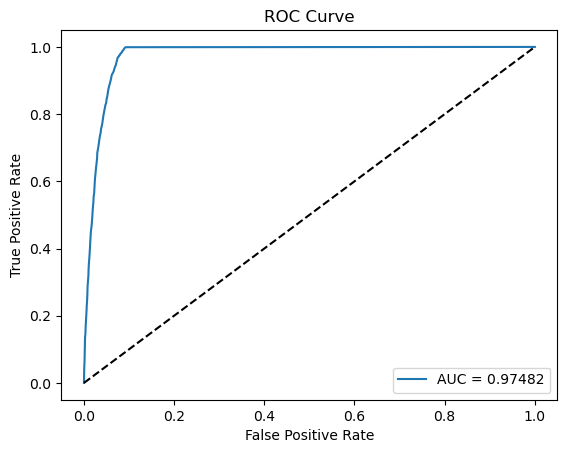

In [86]:
import seaborn as sns

# Group data by date and point of reference (by tile on each day)
grouped = data_test.groupby(['Date', 'Reference'])

# tile_test samples - ground truth for tiles
tile_test = []
tile_pred = []
tile_prob = []

# Get the actual tile data from training data
for name, group in grouped:
    reference = group[group['Neighbor Number'] == 5]
    frost_val = reference['FROST'].values[0]
    frost_pred = reference['PRED'].values[0]
    frost_prob = reference['PROB'].values[0]
    tile_test.append(frost_val)
    tile_pred.append(frost_pred)
    tile_prob.append(frost_prob)



rows = []
rows.append({'name': 'Random Forest Baseline', 'Accuracy': accuracy_score(tile_test, tile_pred),
             'Recall': recall_score(tile_test, tile_pred), 'Precision': precision_score(tile_test, tile_pred),
             'F1': f1_score(tile_test, tile_pred), 'ROC': roc_auc_score(tile_test, tile_prob)
            })
display(pd.DataFrame(rows))
             
# Evaluate baseline accuracy - this has no spatial usage
plot_confusion_matrix(tile_test, tile_pred, 'Random Forest Baseline')
plot_roc_curve(tile_test, tile_prob)

This is our baseline. It does not use any spatial data. It simply uses a random forest to predict if there is frost at a given point of reference, given only the data from that point of reference. Next, we will use the frost predictions from surrounding pixels (neighbors) of a given tile (pixels surrounding a point of reference) to see if we can improve on the baseline.

First, we will use a Random Forest, and a function to account for surrounding pixel frost values. We will use the probabilities of each tile. If the probability after the function outputs > 0.5, we predict frost. Otherwise, we predict no frost.

,name,Accuracy,Recall,Precision,F1,ROC
0,Random Forest - Weight = 0.5,0.944205,0.708714,0.681564,0.694874,0.974824


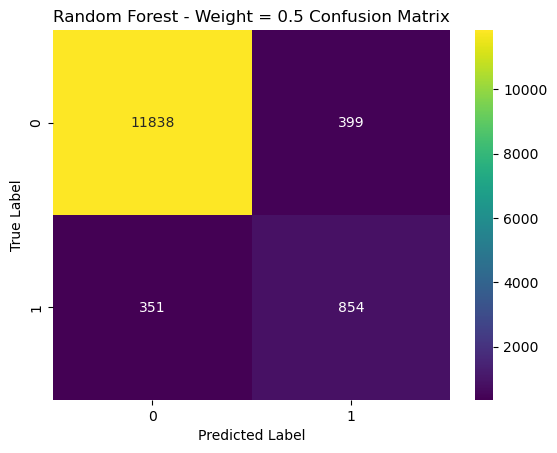

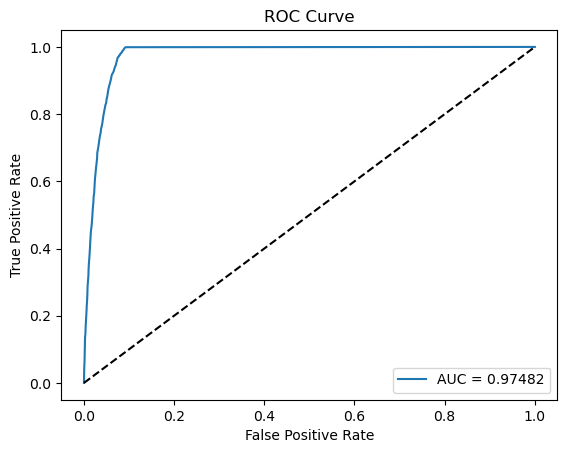

In [90]:
# Group by date and reference - each tile is its own group
grouped = data_test.groupby(['Date', 'Reference'])

# Collect spatial data
tile_pred_spatial = []
tile_prob_spatial = []

# Weight parameter - tunable
weight = .5

# Get the actual tile data from training data
for name, group in grouped:
    # Gets the reference point for a tile
    reference = group[group['Neighbor Number'] == 5]
    # Frost probability from the model for the point of reference
    poi_prob = reference['PROB'].values[0]

    summation = 0
    # Now go through each tile that is not PoI from the neighborhood
    for i in range(1, 10):
        if i != 5:
            pixel = group[group['Neighbor Number'] == i]
            frost_prob = pixel['PROB'].values[0]
            summation += frost_prob
    summation /= 8
    summation *= (1 - weight)

    # Add weight*poi_prob to summation
    final_sum = weight*poi_prob + summation

    # Tile probability is the final sum
    tile_prob_spatial.append(final_sum)
    
    # If probability > .5, predict frost for tile. Else, no frost (0)
    if final_sum > 0.5:
        tile_pred_spatial.append(1)
    else:
        tile_pred_spatial.append(0)

rows = []
rows.append({'name': 'Random Forest - Weight = 0.5', 'Accuracy': accuracy_score(tile_test, tile_pred_spatial),
             'Recall': recall_score(tile_test, tile_pred_spatial), 'Precision': precision_score(tile_test, tile_pred_spatial),
             'F1': f1_score(tile_test, tile_pred_spatial), 'ROC': roc_auc_score(tile_test, tile_prob_spatial)
            })
display(pd.DataFrame(rows))
             
# Evaluate baseline accuracy - this has no spatial usage
plot_confusion_matrix(tile_test, tile_pred_spatial, 'Random Forest - Weight = 0.5')
plot_roc_curve(tile_test, tile_prob_spatial)

We didn't see any differences here compared to the baseline, but let's tune the weight parameter.

In [94]:
# Weight parameter - tunable
weights = [.1, .2, .3, .4, .5, .6, .7, .8, .9]

# Store results in DF
rows = []
for weight in weights:
    tile_pred_spatial = []
    tile_prob_spatial = []
    for name, group in grouped:
        # Gets the reference point for a tile
        reference = group[group['Neighbor Number'] == 5]
        # Frost probability from the model for the point of reference
        poi_prob = reference['PROB'].values[0]

        summation = 0
        # Now go through each tile that is not PoI from the neighborhood
        for i in range(1, 10):
            if i != 5:
                pixel = group[group['Neighbor Number'] == i]
                frost_prob = pixel['PROB'].values[0]
                summation += frost_prob
        summation /= 8
        summation *= (1 - weight)

        # Add weight*poi_prob to summation
        final_sum = weight*poi_prob + summation

        # Tile probability is the final sum
        tile_prob_spatial.append(final_sum)
    
        # If probability > .5, predict frost for tile. Else, no frost (0)
        if final_sum > 0.5:
            tile_pred_spatial.append(1)
        else:
            tile_pred_spatial.append(0)

    rows.append({'name': f'Random Forest - Weight = {weight}', 'Accuracy': accuracy_score(tile_test, tile_pred_spatial),
             'Recall': recall_score(tile_test, tile_pred_spatial), 'Precision': precision_score(tile_test, tile_pred_spatial),
             'F1': f1_score(tile_test, tile_pred_spatial), 'ROC': roc_auc_score(tile_test, tile_prob_spatial)
            })
    
rows.append({'name': 'Baseline RF (weight = 1)', 'Accuracy': accuracy_score(tile_test, tile_pred),
             'Recall': recall_score(tile_test, tile_pred), 'Precision': precision_score(tile_test, tile_pred),
             'F1': f1_score(tile_test, tile_pred), 'ROC': roc_auc_score(tile_test, tile_prob)
            })

display(pd.DataFrame(rows))
    

,name,Accuracy,Recall,Precision,F1,ROC
0,Random Forest - Weight = 0.1,0.944205,0.719502,0.677873,0.698068,0.974824
1,Random Forest - Weight = 0.2,0.944205,0.708714,0.681564,0.694874,0.974824
2,Random Forest - Weight = 0.3,0.944205,0.708714,0.681564,0.694874,0.974824
3,Random Forest - Weight = 0.4,0.944205,0.708714,0.681564,0.694874,0.974824
4,Random Forest - Weight = 0.5,0.944205,0.708714,0.681564,0.694874,0.974824
5,Random Forest - Weight = 0.6,0.944205,0.708714,0.681564,0.694874,0.974824
6,Random Forest - Weight = 0.7,0.944205,0.708714,0.681564,0.694874,0.974824
7,Random Forest - Weight = 0.8,0.944205,0.708714,0.681564,0.694874,0.974824
8,Random Forest - Weight = 0.9,0.944205,0.708714,0.681564,0.694874,0.974824
9,Baseline RF (weight = 1),0.944205,0.708714,0.681564,0.694874,0.974824


All accuracy scores are nearly the same, indicating the function does not change our output much. However, we note that we see increased recall and F1 scores for the RF with a function weight parameter of 0.1. I would suggest this model captures what we are most interested in with our solutoin--that is, we want to ensure we are not missing frost presence when it is there.

,name,Accuracy,Recall,Precision,F1,ROC
0,Random Forest - Weight = 0.1,0.944205,0.719502,0.677873,0.698068,0.974824


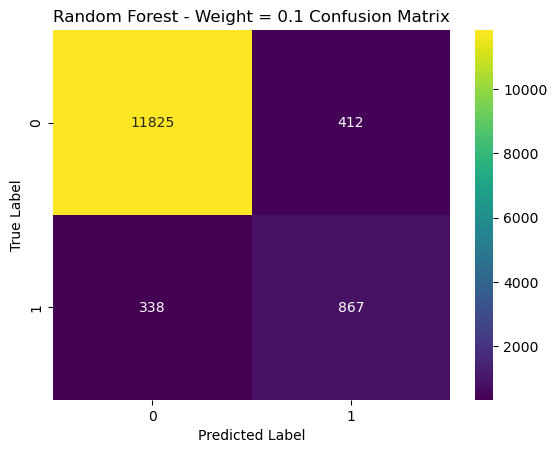

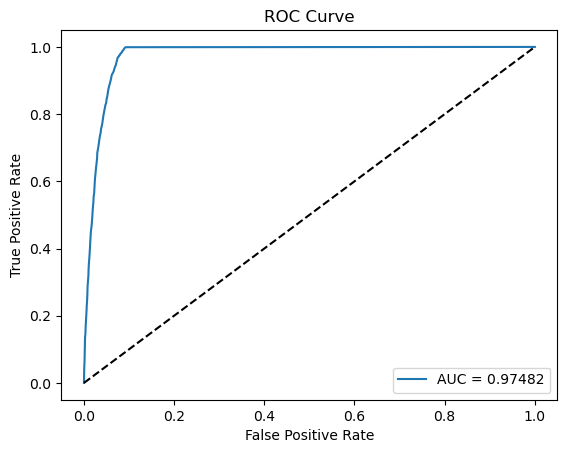

In [97]:
# Group by date and reference - each tile is its own group
grouped = data_test.groupby(['Date', 'Reference'])

# Collect spatial data
tile_pred_spatial = []
tile_prob_spatial = []

# Weight parameter - tunable
weight = .1

# Get the actual tile data from training data
for name, group in grouped:
    # Gets the reference point for a tile
    reference = group[group['Neighbor Number'] == 5]
    # Frost probability from the model for the point of reference
    poi_prob = reference['PROB'].values[0]

    summation = 0
    # Now go through each tile that is not PoI from the neighborhood
    for i in range(1, 10):
        if i != 5:
            pixel = group[group['Neighbor Number'] == i]
            frost_prob = pixel['PROB'].values[0]
            summation += frost_prob
    summation /= 8
    summation *= (1 - weight)

    # Add weight*poi_prob to summation
    final_sum = weight*poi_prob + summation

    # Tile probability is the final sum
    tile_prob_spatial.append(final_sum)
    
    # If probability > .5, predict frost for tile. Else, no frost (0)
    if final_sum > 0.5:
        tile_pred_spatial.append(1)
    else:
        tile_pred_spatial.append(0)

rows = []
rows.append({'name': 'Random Forest - Weight = 0.1', 'Accuracy': accuracy_score(tile_test, tile_pred_spatial),
             'Recall': recall_score(tile_test, tile_pred_spatial), 'Precision': precision_score(tile_test, tile_pred_spatial),
             'F1': f1_score(tile_test, tile_pred_spatial), 'ROC': roc_auc_score(tile_test, tile_prob_spatial)
            })
display(pd.DataFrame(rows))
             
# Evaluate baseline accuracy - this has no spatial usage
plot_confusion_matrix(tile_test, tile_pred_spatial, 'Random Forest - Weight = 0.1')
plot_roc_curve(tile_test, tile_prob_spatial)

In [98]:
# Save test data used from this file to an output file. 
# This is so that you don't have to run the initial lines that take time to move data into proper columns.

# Save updated test data
data_test.to_csv('spatial_test.csv', index=False)

In [ ]:
# Function used for the value-cost matrix of a given model. 
# Pass in model predictions and ground truth to get the cost/value of a model
def get_cost(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    return (-2)*fn + (-1)*fp + tp